## Önişleme, Öznitelik Çıkartımı ve *Pipeline* İşlevselliği

Şimdiye kadar mevcut veri setlerini yükledik ve doğrudan kullandık. Ancak gerçek problemlerde çoğu zaman veriyi çeşitli önişlemlerden geçirmek, doğru formata sokmak (scikit-learn için `[nokta_sayisi oznitelik_sayisi]` şeklinde bir 2 boyutlu dizin), her algoritma için geçerli olmasa da sayısal değerlere çevirmek (kategorik veriler, yazı vb.) ve/veya veriden öznitelik çıkartmak gereklidir. Scikit-learn kütühanesinde bu gereksinimler için bir takım işlevler mevcuttur. Bu işlevler ana olarak 
`preprocessing`, `feature_extraction` ve `pipeline` modülleri içerisindedir.

In [1]:
#Ortamı hazırlayalım
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import pipeline

### Ölçeklendirme (Scaling)

Verilerin boyutları farklı ölçeklerde olabilir. Bu durumun öğrenme algoritmasını etkilememesi için verilerin belirli standardizasyondan geçirilmesi önerilir. Ölçeklendirme için yöntemler:

* Z-Normalization: Verinin her boyutunu 0 ortalama ve 1 standart sapma olacak şekilde düzenlemek. Scikit
* Min-Max Scaling: Verinin her boyutunu iki değer arasında kalacak şekilde düzenlemek. Genelde bu aralık [0,1] ya da [-1,1] olarak seçilir.
* Max Absolute Value Scaling: Verinin her boyutunun mutlak değerinin belirli bir değerden küçük olacak şekilde düzenlemek. Genelde bu değer 1 olur. Sadece çarpma işlemi olduğu için aralıklı veriler ile kullanılması uygundur.
* Robust Scaling: Veride fazla sayıda **aykırı** değer normal ölçeklendirme işlemlerini kötü etkileyebilir. Medyan ve çeyrek genişlik değerleri kullanan bir ölçekleme bu tip veriler için uygundur.

Uyarı: Çok fazla 0 içeren aralıklı verilerin (sparse data) önişlem adımlarından geçirilecekse dikkat edilmelidir. Aksi takdirde seyrek yapıları bozulabilir. Önişleme yapılırken uygun yaklaşımlar seçilmelidir. En uygun yöntemler, merkezleme yapmayan yöntemlerdir.

Yapay öğrenme uygulamalarında ölçeklendirme bilgilerini (örneğin hangi değeri ekledik/çıkardık ve hangi değer ile çarptık/böldük) tutmak isteriz. Bunun nedeni modelin yürürlüğe alındığı zaman gelen verilerin de aynı şekilde ölçeklendirme gereksinimidir.

Şimdi bir kaç örnek görelim:

In [2]:
X = np.array([[ 1., -1.,  2.],
              [ 2.,  0.,  0.],
              [ 0.,  1., -1.],
              [ 1.,  0.,  1.]])
print('Orjinal:')
print(X)

Orjinal:
[[ 1. -1.  2.]
 [ 2.  0.  0.]
 [ 0.  1. -1.]
 [ 1.  0.  1.]]


Z-Normalization:

In [3]:
Xzn = preprocessing.scale(X)
print('Z-Normalized:')
print(Xzn)
print()

print('Ortalama ve Standart Sapma')
print(Xzn.mean(axis=0),Xzn.std(axis=0))
print()

#Ölçekleme bilgisini saklayacak şekilde:
scaler = preprocessing.StandardScaler()
# Değerleri hesapla
scaler.fit(X) 
print('Ölçekleme yapacak sınıf:')
print(scaler)
print('Ölçekleme değerleri:')
print(scaler.mean_, scaler.scale_)
print('Z-Normalized:')
#Gelen veriyi ölçeklendir. İlk veri olmasına gerek yok
print(scaler.transform(X))

Z-Normalized:
[[ 0.         -1.41421356  1.34164079]
 [ 1.41421356  0.         -0.4472136 ]
 [-1.41421356  1.41421356 -1.34164079]
 [ 0.          0.          0.4472136 ]]

Ortalama ve Standart Sapma
[0.00000000e+00 0.00000000e+00 1.38777878e-17] [1. 1. 1.]

Ölçekleme yapacak sınıf:
StandardScaler(copy=True, with_mean=True, with_std=True)
Ölçekleme değerleri:
[1.  0.  0.5] [0.70710678 0.70710678 1.11803399]
Z-Normalized:
[[ 0.         -1.41421356  1.34164079]
 [ 1.41421356  0.         -0.4472136 ]
 [-1.41421356  1.41421356 -1.34164079]
 [ 0.          0.          0.4472136 ]]


MinMax

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
#Değerleri hesapla ve hemen orjinal datayı ölçeklendir
Xmm = min_max_scaler.fit_transform(X)
print('[0,1] aralığına:')
print(Xmm)
print()
print('Ölçekleme değerleri:')
print(min_max_scaler.scale_, min_max_scaler.min_)
Y = np.array([[1.5, -1.,1.5]])
print('Başka veri ölçekleme')
print(Y)
print(scaler.transform(Y))
print()

print('[-1,1] aralığına')
min_max_scaler = preprocessing.MinMaxScaler()
print(preprocessing.MinMaxScaler(feature_range=[-1,1]).fit_transform(X))
print()

[0,1] aralığına:
[[0.5        0.         1.        ]
 [1.         0.5        0.33333333]
 [0.         1.         0.        ]
 [0.5        0.5        0.66666667]]

Ölçekleme değerleri:
[0.5        0.5        0.33333333] [0.         0.5        0.33333333]
Başka veri ölçekleme
[[ 1.5 -1.   1.5]]
[[ 0.70710678 -1.41421356  0.89442719]]

[-1,1] aralığına
[[ 0.         -1.          1.        ]
 [ 1.          0.         -0.33333333]
 [-1.          1.         -1.        ]
 [ 0.          0.          0.33333333]]



Mutlak Değer Ölçeklemesi (Sparse Veriler için uygun)

In [5]:
max_abs_scaler = preprocessing.MaxAbsScaler()
Xma = max_abs_scaler.fit_transform(X)
print('Mutlak Değer 1e:')
print(Xmm)
print()
print('Ölçekleme değeri:')
print(max_abs_scaler.scale_)
print()

print('Başka veri ölçekleme')
Y = np.array([[ -3., -1.,  4.]])
print(Y)
print(max_abs_scaler.transform(Y))

Mutlak Değer 1e:
[[0.5        0.         1.        ]
 [1.         0.5        0.33333333]
 [0.         1.         0.        ]
 [0.5        0.5        0.66666667]]

Ölçekleme değeri:
[2. 1. 2.]

Başka veri ölçekleme
[[-3. -1.  4.]]
[[-1.5 -1.   2. ]]


Aykırı Değerlerle Ölçekleme

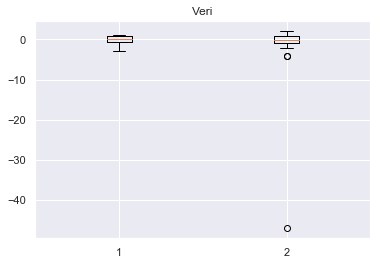

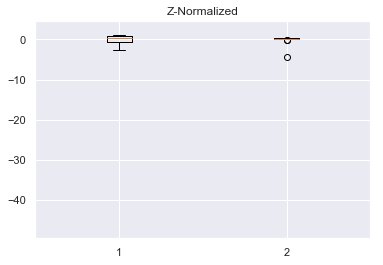

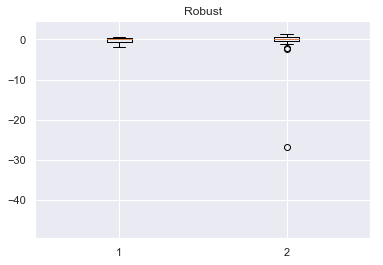

In [6]:
#Ölçeklendirme il alakasız veri yaratılıyor:
Xo = np.random.standard_t(2,(20,2))
plt.boxplot(Xo)
plt.title('Veri')
down, up = plt.ylim()
plt.show()


z_scaler = preprocessing.StandardScaler()
Xz = z_scaler.fit_transform(Xo)
plt.boxplot(Xz)
plt.title('Z-Normalized')
plt.ylim(down,up)
plt.show()

robust_scaler = preprocessing.RobustScaler()
Xrs = robust_scaler.fit_transform(Xo)
plt.boxplot(Xrs)
plt.title('Robust')
plt.ylim(down,up)
plt.show()


Bazı veri türleri veya problemler için boyutların teker teker ölçeklenmesi uygun değildir. Verilerin beraber ölçeklenmesi gerekebilir. Buna örnek olarak veri ağartması (whitening) verilebilir. Başka bir örnek ise, verinin birim norma sahip olacak şekilde düzenlenmesidir.

In [7]:
print('Orjinal:')
print(X)
print()

Xn = preprocessing.normalize(X, norm='l2')
print('Birim Vektöre Normalize:')
print(Xn)  
print()

#Bu işlemin belirli bir değeri yoktur, gelen veriye göre yapılır. 
#Ancak aynı işleveselliği sürdürmesi için, sınıf versiyonu da mevcuttur
normalizer = preprocessing.Normalizer()
print(normalizer)

Orjinal:
[[ 1. -1.  2.]
 [ 2.  0.  0.]
 [ 0.  1. -1.]
 [ 1.  0.  1.]]

Birim Vektöre Normalize:
[[ 0.40824829 -0.40824829  0.81649658]
 [ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]
 [ 0.70710678  0.          0.70710678]]

Normalizer(copy=True, norm='l2')


### Kategorik Verilerin Kodlanması

Bir çok öğrenme algoritması, girdi olarak sayı değeleri (vektör, matris vb. dahil) bekler. Bu yüzden kategorik verileri bu şekilde kodlamak gereklidir. Mesela verimiz müşteri ile ilgili bilgiler olsun: `[cinsiyet, şehir, meslek]`. Cinsiyet için `[kadın, erkek]`, şehir için `[ankara, istanbul, izmir]` ve meslek `[özel, kamu, serbest, emekli]` seçenekleri olsun. 

Bildiğimiz üzere doğrudan tamsayı vermek iyi bir fikir değil. Bu yüzden *one-hot* kodlaması yapıyoruz. Scikit-learn'de:

In [8]:
enc = preprocessing.OneHotEncoder()

M = [['erkek', 'ankara', 'kamu'], 
     ['kadın', 'istanbul', 'özel'],
     ['kadın', 'izmir', 'emekli'],
     ['erkek', 'istanbul', 'serbest']]
#Kategorileri veriden çıkartarak
enc.fit(M)
print('Kodlayıcı:')
print(enc)
print('Veriden kodlamaya:')
# 2 (cinsiyet) + 3 (şehir) + 4(meslek) = 9 boyutlu
print(enc.transform([['kadın', 'istanbul', 'serbest'],
                     ['erkek', 'ankara', 'emekli']]).toarray())
print('Kategoriler:')
print(enc.categories_)
print()
#Kategorileri el ile vererek
cinsiyet = ['kadın', 'erkek'] 
sehir = ['ankara', 'istanbul', 'izmir']
meslek = ['özel', 'kamu', 'serbest', 'emekli']
enc2 = preprocessing.OneHotEncoder(categories=[cinsiyet, sehir, meslek])
print('Kodlayıcı:')
print(enc2)
#Yine de fit çağırmamız gerekli
enc2.fit(M)
print('Veriden kodlamaya:')
print(enc2.transform([['kadın', 'istanbul', 'serbest'],
                     ['erkek', 'ankara', 'emekli']]).toarray())
print()

#Eğer beklenmedik kategorik veri gelme ihtimali varsa:
enc3 = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc3.fit(M) 
print('Kodlayıcı:')
print(enc3)
print('Veride bulunmayan kategorik veri gelince hepsi 0 olan uygun boyutta bir vektör atıyor:')
print(enc3.transform([['kadın', 'Bursa', 'kamu']]).toarray())
print()


Kodlayıcı:
OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)
Veriden kodlamaya:
[[0. 1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0.]]
Kategoriler:
[array(['erkek', 'kadın'], dtype=object), array(['ankara', 'istanbul', 'izmir'], dtype=object), array(['emekli', 'kamu', 'serbest', 'özel'], dtype=object)]

Kodlayıcı:
OneHotEncoder(categorical_features=None,
       categories=[['kadın', 'erkek'], ['ankara', 'istanbul', 'izmir'], ['özel', 'kamu', 'serbest', 'emekli']],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)
Veriden kodlamaya:
[[1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1.]]

Kodlayıcı:
OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)
Veride bulunmayan kategorik veri gelince hepsi 0 olan uygun boyutta bir vek

Veriler bazen dictionary veri yapıları içinde gelebilir. Bunun için:

In [9]:
from sklearn.feature_extraction import DictVectorizer
dictData = [
    {'fiyat': 1200000, 'oda': 4, 'mahalle': 'Maslak'},
    {'fiyat': 1400000, 'oda': 3, 'mahalle': 'Etiler'},
    {'fiyat':  500000, 'oda': 3, 'mahalle': 'Tuzla'},
    {'fiyat':  900000, 'oda': 2, 'mahalle': 'Etiler'}]
vec = DictVectorizer(sparse=False, dtype=int)
print(vec.fit_transform(dictData))



[[1200000       0       1       0       4]
 [1400000       1       0       0       3]
 [ 500000       0       0       1       3]
 [ 900000       1       0       0       2]]


### Eksik Verilerin Atanması (Imputation)

Gerçek dünyada verilerin bazı boyutları eksik gelebilir. Bunla başa çıkmanın değişik yolları vardır. En basit ve yaygınca kullanılan yöntemler arasında ortalama, medyan, mod veya sabit bir değer kullanmak gelir. 

In [10]:
from sklearn.impute import SimpleImputer
#Ortalama
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6], [5, 3], [4, 4]])       

print('Ortalama:')
Xe = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(Xe))        

imp2 = SimpleImputer(missing_values=np.nan, strategy='median')
imp2.fit([[1, 2], [np.nan, 3], [7, 6]]) 
print('Medyan:')
print(imp2.transform(Xe))

print('Pandastaki Kategorikler üzerinde en sık:')
df = pd.DataFrame([["a", "x"],
                   [np.nan, "y"],
                   ["a", np.nan],
                   ["b", "y"]], dtype="category")

imp3 = SimpleImputer(strategy="most_frequent")
print(imp3.fit_transform(df))

print('Pandastaki Kategorikler üzerinde sabit:')
imp4 = SimpleImputer(strategy="constant", fill_value = 'c')
print(imp4.fit_transform(df))


Ortalama:
[[4.25 2.  ]
 [6.   3.6 ]
 [7.   6.  ]]
Medyan:
[[4. 2.]
 [6. 3.]
 [7. 6.]]
Pandastaki Kategorikler üzerinde en sık:
[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]
Pandastaki Kategorikler üzerinde sabit:
[['a' 'x']
 ['c' 'y']
 ['a' 'c']
 ['b' 'y']]


Eksik veriler, doğrusal regresyon ve korelasyon bilgileri kullanılarak da doldurulabilirler. Bu yöntemler daha iyi çalışmaktadır. Ancak şu an itibariyle scikit-learn kütüphanesinde henüz bulunmamaktadırlar. Yakın zamanda `IterativeImputer` adıyla geleceklerdir.

### Polinom Öznitelikler

Veriye doğrusalsızlık (non-linearity) eklemek, öğrenme açısından faydalı olabilir. Bunun en kolay yöntemlerinden birisi de mevcut verilerin yüksek dereceli ve etkileşimli polinom değerlerini veriye eklemektir. Bunu `PolynomialFeatures` modülü ile yapmak mümkün.

In [11]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
Xp = np.arange(6).reshape(3, 2)
print('Orjinal:')
print(Xp)
poly = PolynomialFeatures(2)
print('Polinom Öznitelikleri Eklenmiş: 1 x1 x2 (x1)^2 x1*x2 (x2)^2')
print(poly.fit_transform(Xp))
poly2 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
print('Sadece etkileşim Polinom Öznitelikleri Eklenmiş: x1 x2 x1x2')
print(poly2.fit_transform(Xp))

Orjinal:
[[0 1]
 [2 3]
 [4 5]]
Polinom Öznitelikleri Eklenmiş: 1 x1 x2 (x1)^2 x1*x2 (x2)^2
[[ 1.  0.  1.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]
Sadece etkileşim Polinom Öznitelikleri Eklenmiş: x1 x2 x1x2
[[ 0.  1.  0.]
 [ 2.  3.  6.]
 [ 4.  5. 20.]]


### Özel Önişleme veya Öznitelik Uygulaması

Veri temizlemek, önişlemek veya öznitelik çıkartmak için bazen özel fonksiyonlar tanımlanmak istenebilir. Bunu yapmanın birçok yolu vardır ancak birazdan açık olacak nedenler için (Pipeline işlevi) aşağıdaki şekilde tanımlanması önerilir.

In [12]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
Xt = np.array([[0, 1], [2, 3]])
print(Xt)
print(np.log1p(Xt))
print(transformer.transform(Xt))

[[0 1]
 [2 3]]
[[0.         0.69314718]
 [1.09861229 1.38629436]]
[[0.         0.69314718]
 [1.09861229 1.38629436]]


### Yazı Öznitelikleri

Yazı verisi ile öğrenme yapmak için vektöre çevrilmeleri gerekir. Bunun için literatürde birçok yöntem vardır. Scikit-learn görece geri kalmış ancak yine de kullanışlı iki öznitelik çıkartma yöntemini destekler. Bunun ilki doğrudan kelime sayılarını vektöre çeviren *bag-of-words* modeli, diğeri de sayıları genel kullanım ile dengeleyen *tf-idf* modelidir.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
ornek = ['bugun hava sicak', 'sicak sicak corbani ic', 'hava su yol elektrik', 'cok yol yaptim bugun']

vec = CountVectorizer()
Xbow = vec.fit_transform(ornek)
display(pd.DataFrame(Xbow.toarray(), columns=vec.get_feature_names()))

vec2 = TfidfVectorizer()
Xtfidf = vec2.fit_transform(ornek)
display(pd.DataFrame(Xtfidf.toarray(), columns=vec.get_feature_names()))



,bugun,cok,corbani,elektrik,hava,ic,sicak,su,yaptim,yol
0,1,0,0,0,1,0,1,0,0,0
1,0,0,1,0,0,1,2,0,0,0
2,0,0,0,1,1,0,0,1,0,1
3,1,1,0,0,0,0,0,0,1,1


,bugun,cok,corbani,elektrik,hava,ic,sicak,su,yaptim,yol
0,0.577350,0.000000,0.00000,0.000000,0.577350,0.00000,0.57735,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.47212,0.000000,0.000000,0.47212,0.74445,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.555283,0.437791,0.00000,0.00000,0.555283,0.000000,0.437791
3,0.437791,0.555283,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.555283,0.437791


Bu öznitelikleri nasıl kullanacağımızı birazdan göreceğiz

### Pipeline: İşlemleri ve Tahminleyicileri Uç Uca Eklemek

Tipik bir yapay öğrenme uygulamasında, verinin üzerinde bir takım işlemler (önişleme, öznitelik hesaplama, öznitelik ekleme, veriyi dönüştürme vb.) yapıldıktan sonra veri öğrenme algoritmasına verilir. Örnek olarak: 
1. Eksik verileri ortalamalar ile kapat
2. Veriyi [-1,1] arasına ölçekle
3. İkinci dereceden polinom öznitelikleri ekle
4. Veriden öğren.

Burada veri bir takım **dönüşümden** geçtikten sonra öğrenme sürecine giriyor. Giriş kısmında, öğrenme algoritmalarının kullandığı Estimator API'yi görmüştük. Benzer bir şekilde dönüştürme algoritmaları için de Transformer API var. Bu API `fit()`, `transform()` ve ikisinin tek bir adımda yapıldığı `fit_transform()` fonskiyonlarını tanımlıyor. 

Scikit-learn bu süreci soyutlaştırmak ve kolaylaştırmak için `pipeline` işlevselliğini tanımlanış. Bu soyutlaştırma, birden çok transformerdan geçen verinin, en son hali ile bir estimatora girmesini temsil ediyor.



In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                     preprocessing.MinMaxScaler(),
                     PolynomialFeatures(degree=2),
                     LinearRegression())
print(pipe)

#eğer her adıma isim vermek istersek:
from sklearn.pipeline import Pipeline
steps = [('impute', SimpleImputer(missing_values=np.nan, strategy='mean')), 
         ('scale', preprocessing.MinMaxScaler()),
         ('poly', PolynomialFeatures(degree=2)),
         ('learn', LinearRegression())]
pipe2 = Pipeline(steps)
print(pipe2)

Xpp = np.array([[ np.nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   np.nan, 6  ],
              [ 8,   8,   1  ]])

ypp = np.array([14.2, 15.9, -1.01,  7.93, -5.2])
pipe.fit(Xpp, ypp) 
print()
print(ypp)
print(pipe.predict(Xpp))

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('learn', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

[14.2  15.9  -1.01  7.93 -5.2 ]
[14.2  15.9  -1.01  7.93 -5.2 ]
